In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
# Find the path to the Google Drive directory
import os

data_dir = '/content/gdrive/MyDrive/CellsDatasetPNG'
#data_dir = 'C:/Users/billy/Documents/PythonScripts/CellsDatasetPNG'

import tensorflow as tf
import numpy as np
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#train_dir = 'C:/Users/billy/Documents/PythonScripts/CellsDatasetPNG/train'
#test_dir = 'C:/Users/billy/Documents/PythonScripts/CellsDatasetPNG/test'

train_dir = '/content/gdrive/MyDrive/CellsDatasetPNG/train'
test_dir = '/content/gdrive/MyDrive/CellsDatasetPNG/test'

print("Training directory contents:", os.listdir(train_dir))
print("Testing directory contents:", os.listdir(test_dir))

Training directory contents: ['Normal', 'Sickle']
Testing directory contents: ['Normal', 'Sickle']


In [4]:
# Define augment
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary')


Found 611 images belonging to 2 classes.
Found 279 images belonging to 2 classes.


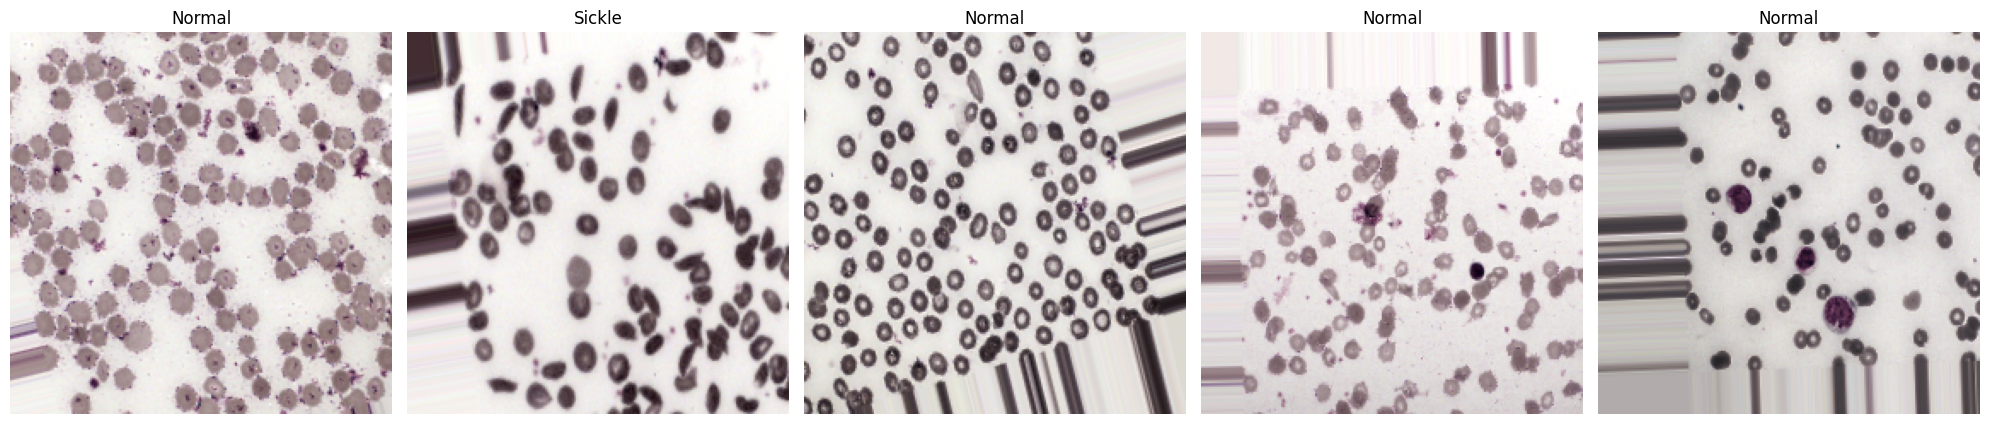

In [5]:
# Plot images
def plot_images(images, titles=None):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    axes = axes.ravel()

    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].axis('off')
        if titles is not None:
            axes[i].set_title(titles[i])

    plt.tight_layout()
    plt.show()

# Get a single batch from the train generator
X_batch, y_batch = next(train_generator)

# Extract the first 5 images and their labels
sample_images = X_batch[:5]
sample_labels = y_batch[:5]
label_names = {0: 'Normal', 1: 'Sickle'}

plot_images(sample_images, [label_names[int(label)] for label in sample_labels])

In [7]:
from tensorflow.keras.regularizers import l2

model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])



model.compile(optimizer=Adam(lr=1e-2), loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
# Create checkpoints
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [9]:
# Train model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint])

Epoch 1/10
39/39 [==============================] - 837s 22s/step - loss: 2.1323 - accuracy: 0.4664 - val_loss: 1.3610 - val_accuracy: 0.4946
Epoch 2/10
39/39 [==============================] - 455s 12s/step - loss: 1.1557 - accuracy: 0.5025 - val_loss: 1.0139 - val_accuracy: 0.4946
Epoch 3/10
39/39 [==============================] - 494s 13s/step - loss: 0.9474 - accuracy: 0.5205 - val_loss: 0.8925 - val_accuracy: 0.4946
Epoch 4/10
39/39 [==============================] - 479s 12s/step - loss: 0.8598 - accuracy: 0.4763 - val_loss: 0.8305 - val_accuracy: 0.4946
Epoch 5/10
39/39 [==============================] - 479s 12s/step - loss: 0.8111 - accuracy: 0.4877 - val_loss: 0.7928 - val_accuracy: 0.5054
Epoch 6/10
39/39 [==============================] - 493s 13s/step - loss: 0.7805 - accuracy: 0.4681 - val_loss: 0.7683 - val_accuracy: 0.5054
Epoch 7/10
39/39 [==============================] - 460s 12s/step - loss: 0.7595 - accuracy: 0.5155 - val_loss: 0.7514 - val_accuracy: 0.4946
Epoch 

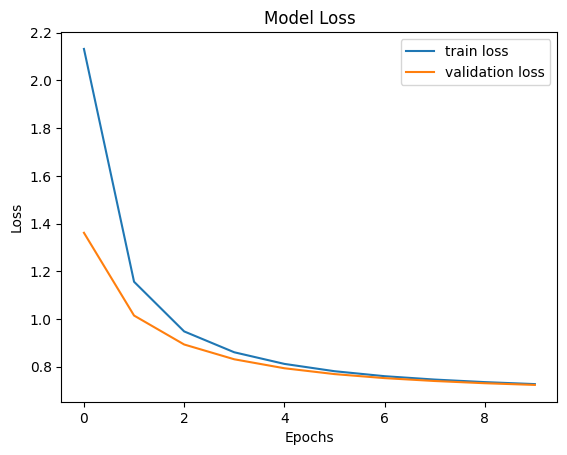

In [11]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

# Evaluate the model and compute the confusion matrix
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred = np.round(y_pred).flatten()

cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
plt.xticks([0,1])
plt.yticks([0,1])
plt.xlabel('Predicted label')
plt.ylabel('True label')

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

 1/18 [>.............................] - ETA: 1:42